<a href="https://colab.research.google.com/github/donbcolab/AIE3/blob/main/brain_tumor_hf_ds_v1_valid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brain Tumor Image Dataset - Hugging Face Dataset Creation

This notebook processes a brain tumor image dataset with COCO-format annotations and creates a Hugging Face Dataset.

Key learnings and decisions while creating this brain tumor image dataset for Hugging Face.

1. Data Structure:
   - The dataset contains brain tumor images with COCO-format annotations.
   - Annotations include bounding boxes and polygon segmentations.
   - Categories are structured as: ID 0 (Tumor), ID 1 (0), ID 2 (1), with 1 and 2 being subcategories of Tumor.

2. Segmentation Characteristics:
   - Segmentations are not rectangular but complex polygons.
   - 100% of segmentations are near their bounding boxes.
   - 100% of sampled annotations have valid polygon segmentations.

3. Key Adjustments:
   - We adjusted the 'features' definition to accommodate complex polygon segmentations.
   - The ClassLabel for 'category_id' was updated to ['Tumor', '0', '1'] to match the actual data structure.

4. Data Loading Considerations:
   - Image data is stored as bytes after being read with OpenCV.
   - Segmentation data needs to be carefully handled to maintain its list-of-lists structure.

5. Verification Steps:
   - We implemented functions to verify polygon validity and dataset structure.
   - These checks are crucial before pushing the dataset to the Hugging Face Hub.

6. Performance and Efficiency:
   - We used tqdm for progress tracking during image loading, which is helpful for large datasets.
   - The dataset creation process involves reading and encoding many images, which can be time-consuming.

7. Hugging Face Dataset Structure:
   - The dataset is created using the Hugging Face Datasets library, which has specific requirements for data types and structures.
   - We needed to ensure that all data types in the pandas DataFrame matched the defined features.

8. Potential Future Work:
   - The current implementation doesn't push to the Hugging Face Hub automatically. This step should be done manually after thorough verification.
   - Depending on the specific use case, additional preprocessing or data augmentation steps might be necessary.

## 1. Setup and Imports

This section imports necessary libraries and sets up the environment.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -qU pyarrow==14.0.1 requests==2.31.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.0/38.0 MB 45.6 MB/s eta 0:00:00


In [3]:
!pip install -qU datasets==2.11.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 770.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 17.6 MB/s eta 0:00:00


In [4]:
import os
import json
import pandas as pd
from datasets import Dataset, Features, ClassLabel, Value, Sequence, Image
from tqdm.auto import tqdm
import cv2

## 2. Constants and Configuration
Define constants and configurations used throughout the notebook.


In [5]:
HF_DATASET_NAME = 'brain-tumor-image-dataset-semantic-segmentation'
SOURCE_JSON = "/content/drive/MyDrive/kaggle/datasets/brain-tumor-image-dataset-semantic-segmentation/valid/_annotations.coco.json"
SOURCE_IMAGE_DIR = "/content/drive/MyDrive/kaggle/datasets/brain-tumor-image-dataset-semantic-segmentation/valid"


## 3. Feature Definition
Define the structure of the Hugging Face Dataset.

In [6]:
features = Features({
    'file_name': Value(dtype='string'),
    'image': Image(),
    'id': Value(dtype='int64'),
    'category_id': ClassLabel(names=['Tumor', '0', '1']),
    'bbox': Sequence(feature=Value(dtype='float32'), length=4),
    'segmentation': Sequence(Sequence(Value(dtype='float32'))),
    'area': Value(dtype='float32'),
    'iscrowd': Value(dtype='int64'),
    'height': Value(dtype='int64'),
    'width': Value(dtype='int64'),
    'date_captured': Value(dtype='string'),
    'license': Value(dtype='int64')
})

## 4. Data Loading and Preprocessing
Functions to load and preprocess the COCO-format data.

In [7]:
def verify_source_data():
    with open(SOURCE_JSON, 'r') as f:
        data = json.load(f)

    print("Categories:")
    for category in data['categories']:
        print(f"ID: {category['id']}, Name: {category['name']}, Supercategory: {category['supercategory']}")

    category_counts = pd.DataFrame(data['annotations'])['category_id'].value_counts().sort_index()
    print("\nCategory distribution in annotations:")
    print(category_counts)

    # Check for images with multiple bounding boxes
    image_bbox_counts = pd.DataFrame(data['annotations'])['image_id'].value_counts()
    print(f"\nImages with multiple bounding boxes: {(image_bbox_counts > 1).sum()}")
    print(f"Max bounding boxes in an image: {image_bbox_counts.max()}")

In [8]:
def load_data_to_df():
    with open(SOURCE_JSON, 'r') as f:
        data = json.load(f)

    images = pd.DataFrame(data['images'])
    annotations = pd.DataFrame(data['annotations'])

    df = pd.merge(images, annotations, left_on='id', right_on='image_id', suffixes=('', '_ann'))

    # Drop duplicate columns
    df = df.drop(columns=['id_ann', 'image_id'])

    # Add the full image path
    df['image'] = df['file_name'].apply(lambda x: os.path.join(SOURCE_IMAGE_DIR, x))

    # Ensure all required columns are present
    for column in features.keys():
        if column not in df.columns and column != 'image':
            df[column] = None

    return df

## 5. Dataset Creation
Function to create the Hugging Face Dataset from the preprocessed data.

In [9]:
def create_hf_dataset(df, hf_dataset_name):
    # Convert 'image' column to image data
    def load_image(image_path):
        img = cv2.imread(image_path)
        if img is not None:
            return cv2.imencode('.jpg', img)[1].tobytes()
        return None

    tqdm.pandas(desc="Loading images")
    df['image'] = df['image'].progress_apply(load_image)

    # Ensure datatypes match the features
    df['bbox'] = df['bbox'].apply(lambda x: [float(i) for i in x])
    df['segmentation'] = df['segmentation'].apply(lambda x: [[float(i) for i in poly] for poly in x])
    df['area'] = df['area'].astype('float32')

    dataset = Dataset.from_pandas(df, features=features)
    print(f"Dataset created successfully with {len(dataset)} examples.")
    return dataset

## 6. Verification Functions
Functions to verify the integrity and structure of the data and created dataset.

In [10]:
import json
from collections import Counter

with open(SOURCE_JSON, 'r') as f:
    coco_data = json.load(f)

category_ids = [ann['category_id'] for ann in coco_data['annotations']]
id_counts = Counter(category_ids)

categories = {cat['id']: cat['name'] for cat in coco_data['categories']}

print("Category ID counts:", id_counts)
print("Category mappings:", categories)

# Automated verification
expected_categories = {0: 'Tumor', 1: '0', 2: '1'}
assert categories == expected_categories, f"Category mismatch. Expected {expected_categories}, got {categories}"
assert set(id_counts.keys()) == {1, 2}, f"Unexpected category IDs found: {set(id_counts.keys())}"

Category ID counts: Counter({2: 219, 1: 210})
Category mappings: {0: 'Tumor', 1: '0', 2: '1'}


In [11]:
def is_valid_polygon(segmentation):
    # Check if it's a list of lists
    if not isinstance(segmentation, list) or not all(isinstance(poly, list) for poly in segmentation):
        return False

    # Check if each polygon has at least 6 coordinates (3 points)
    if not all(len(poly) >= 6 and len(poly) % 2 == 0 for poly in segmentation):
        return False

    return True

sample_annotations = coco_data['annotations'][:100]
valid_count = sum(is_valid_polygon(ann['segmentation']) for ann in sample_annotations)
valid_percentage = (valid_count / len(sample_annotations)) * 100
print(f"{valid_percentage:.2f}% of sampled annotations have valid polygon segmentations")

100.00% of sampled annotations have valid polygon segmentations


In [12]:
def verify_dataset(dataset):
    print(f"Dataset contains {len(dataset)} examples.")
    print("Sample of the first example:")
    print(dataset[0])

    # Check if all required fields are present
    required_fields = ['file_name', 'image', 'id', 'category_id', 'bbox', 'segmentation', 'area']
    for field in required_fields:
        if field not in dataset[0]:
            print(f"Warning: '{field}' is missing from the dataset.")

    # Verify image data
    if isinstance(dataset[0]['image'], bytes):
        print("Image data is stored as bytes.")
    else:
        print("Warning: Image data is not stored as bytes.")

    # Verify segmentation data
    if isinstance(dataset[0]['segmentation'], list) and isinstance(dataset[0]['segmentation'][0], list):
        print("Segmentation data is stored as a list of lists.")
    else:
        print("Warning: Segmentation data is not stored as a list of lists.")

    print("Dataset verification complete.")

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def visualize_samples(dataset, num_samples=5):
    """Visualize a few sample images with annotations."""
    for i in range(num_samples):
        example = dataset[i]

        # Load image
        img = Image.open(os.path.join(SOURCE_IMAGE_DIR, example['file_name']))
        plt.figure(figsize=(10, 10))
        plt.imshow(img)

        # Draw bounding box
        bbox = example['bbox']
        rect = plt.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3],
                             fill=False, edgecolor='red', linewidth=2)
        plt.gca().add_patch(rect)

        # Draw segmentation
        seg = np.array(example['segmentation']).reshape(-1, 2)
        plt.plot(seg[:, 0], seg[:, 1], color='blue', linewidth=2)

        plt.title(f"Category: {example['category_id']}")
        plt.axis('off')
        plt.show()

## 7. Main Execution
The main workflow to create and verify the dataset.

In [13]:
# Load and prepare the data
df = load_data_to_df()

# Create the dataset
dataset = create_hf_dataset(df, HF_DATASET_NAME)

# Verify the dataset
verify_dataset(dataset)

Loading images:   0%|          | 0/429 [00:00<?, ?it/s]

Dataset created successfully with 429 examples.
Dataset contains 429 examples.
Sample of the first example:
{'file_name': '1997_jpg.rf.57e306420710246d04c0d5c26e6496c6.jpg', 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7EAD7E17B7C0>, 'id': 0, 'category_id': 1, 'bbox': [116.0, 300.0, 102.5, 143.75], 'segmentation': [[218.75, 300.0, 116.25, 300.0, 116.25, 443.75, 218.75, 443.75, 218.75, 300.0]], 'area': 14734.375, 'iscrowd': 0, 'height': 640, 'width': 640, 'date_captured': '2023-08-19T04:37:54+00:00', 'license': 1}
Segmentation data is stored as a list of lists.
Dataset verification complete.


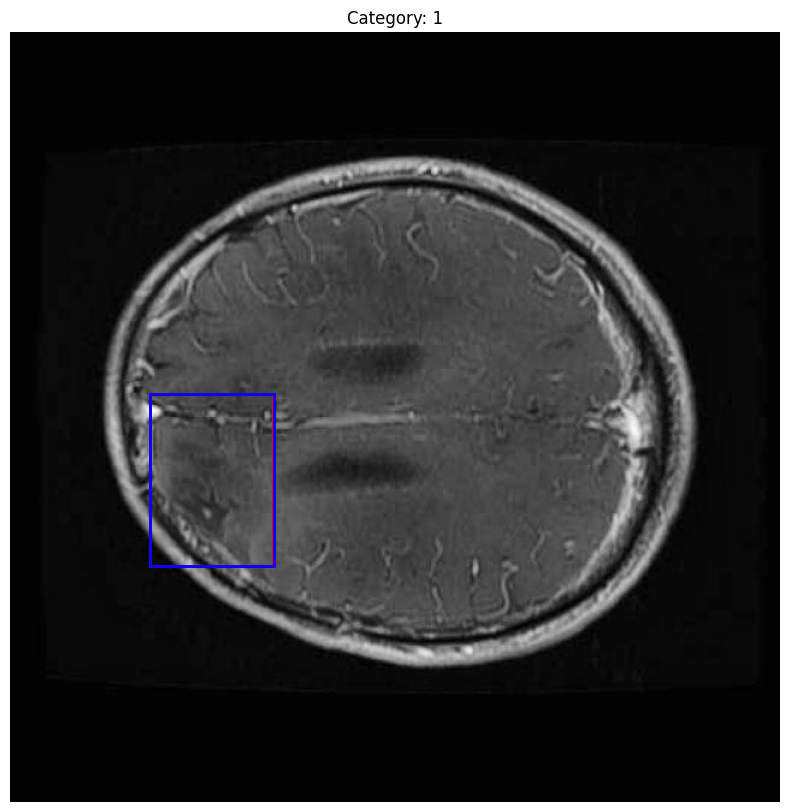

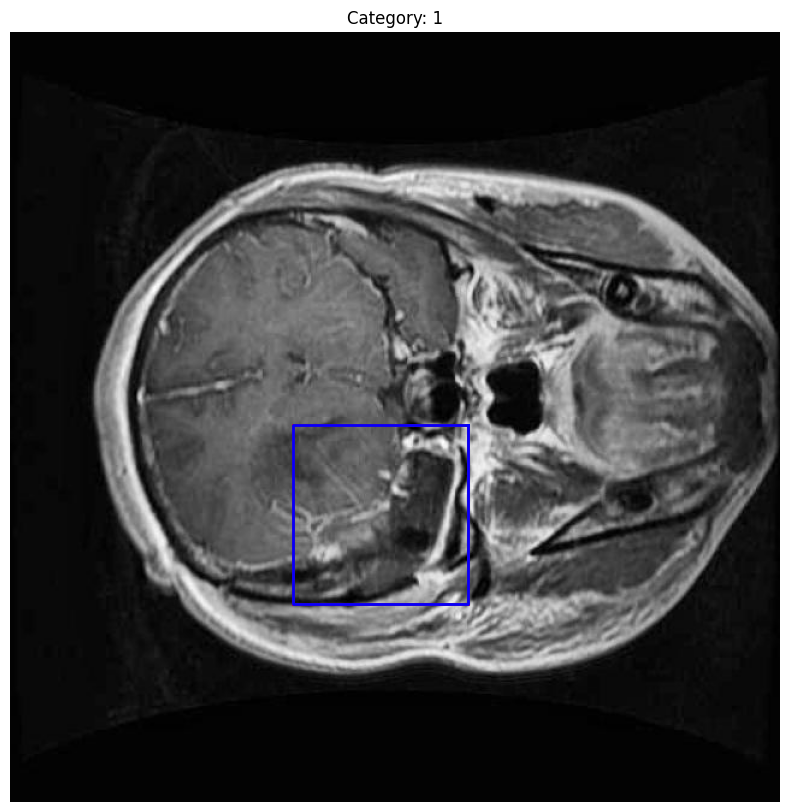

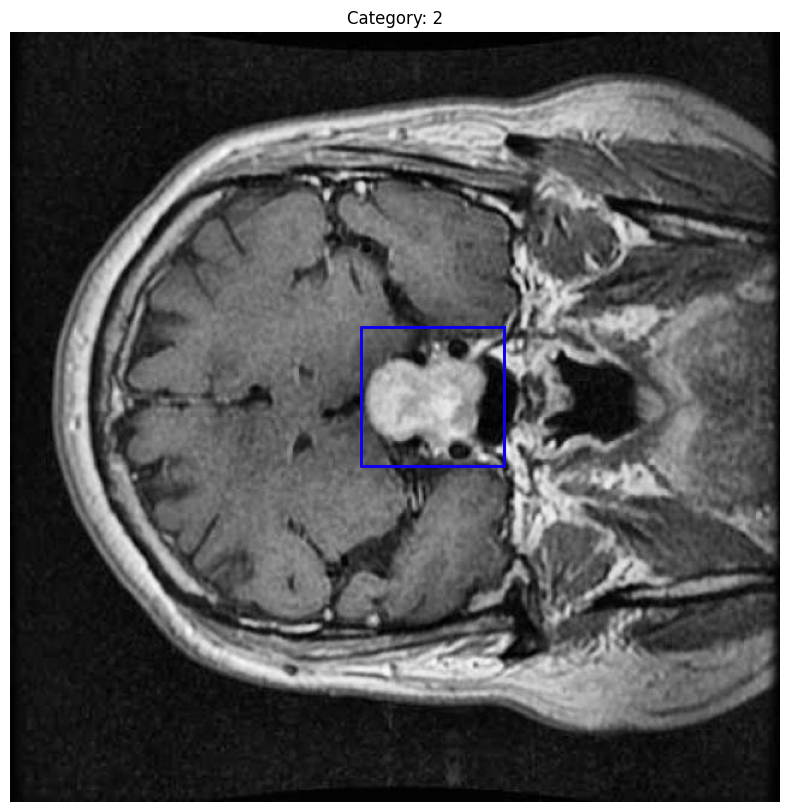

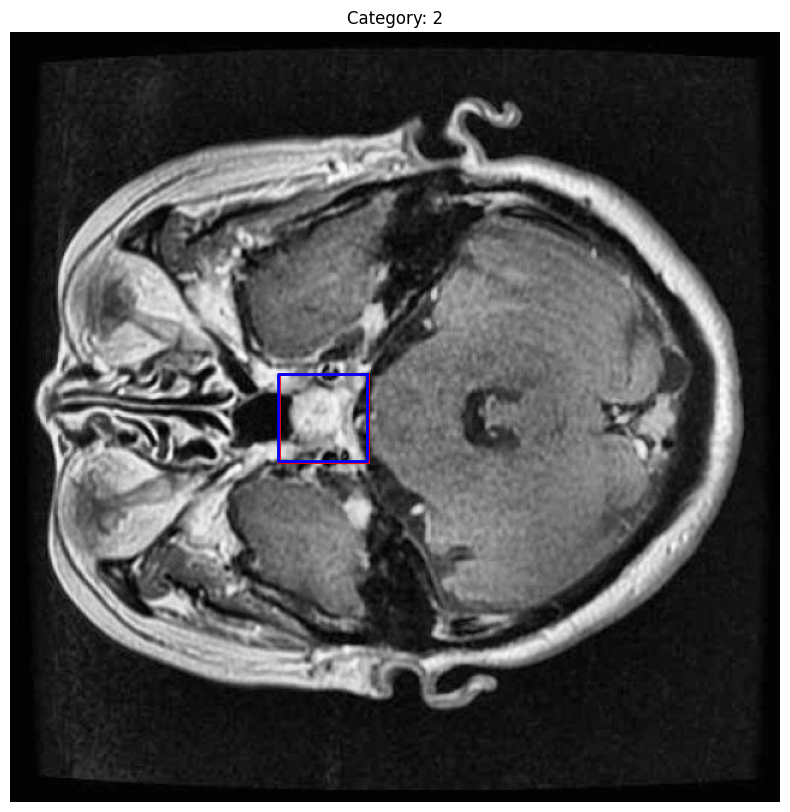

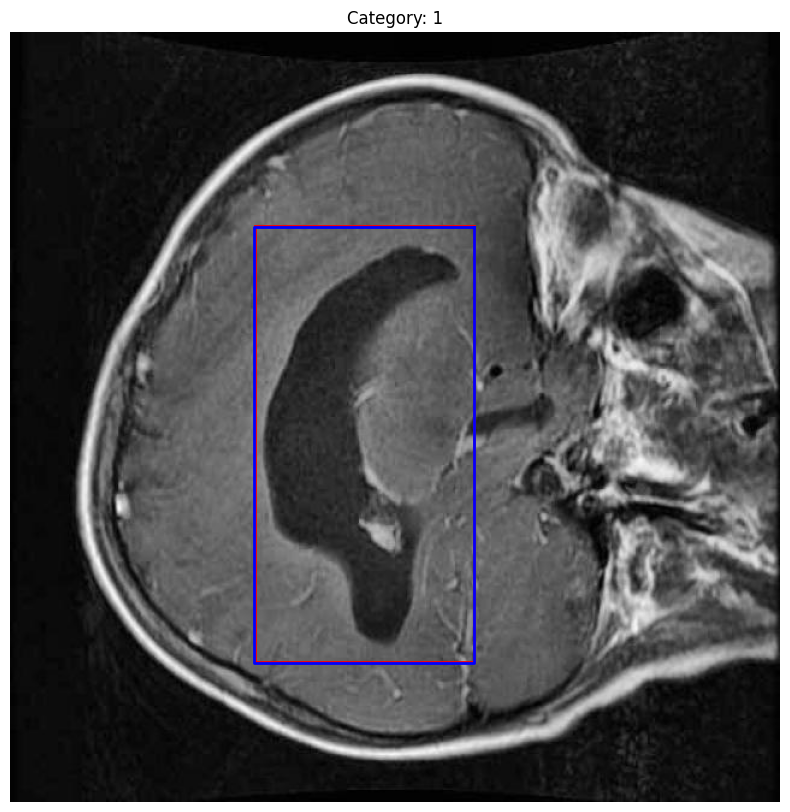

In [17]:
# Visualize samples from the prepared dataset
visualize_samples(dataset)

## 8. (Optional) Upload to Hugging Face Hub
Uncomment this section when ready to upload the dataset to the Hugging Face Hub.

In [14]:
dataset.push_to_hub(HF_DATASET_NAME, split="valid")

Map:   0%|          | 0/429 [00:00<?, ? examples/s]

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]